In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize, RobustScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

seed = 33

### Reading data

In [2]:
df = pd.read_csv('dataset/winequality-white.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Studying data

In [3]:
# Check null values
df.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [4]:
# View features description
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000
mean,6.854736,0.278258,0.334182,6.390437,0.045767,35.305777,138.349765,0.994026,3.188312,0.489871,10.514652,5.878547
std,0.843790,0.100791,0.121009,5.072002,0.021849,17.006169,42.500564,0.002991,0.151018,0.114127,1.230790,0.886671
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991720,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       6
Name: quality, dtype: int64

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

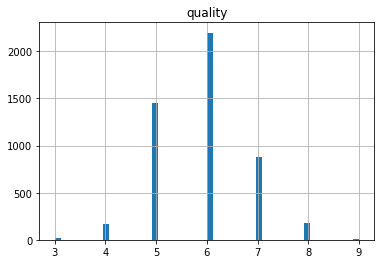

In [6]:
df.hist(column='quality', bins=50)

In [7]:
def iqr_outliers(df):
    out=[]
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    return out

In [8]:
count = 0
for name in list(df.iloc[:, :-1]):
    print(name)
    outliers = iqr_outliers(df[name])
    count += len(outliers)
print('Total: ', count)

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
Total:  1063


<AxesSubplot:>

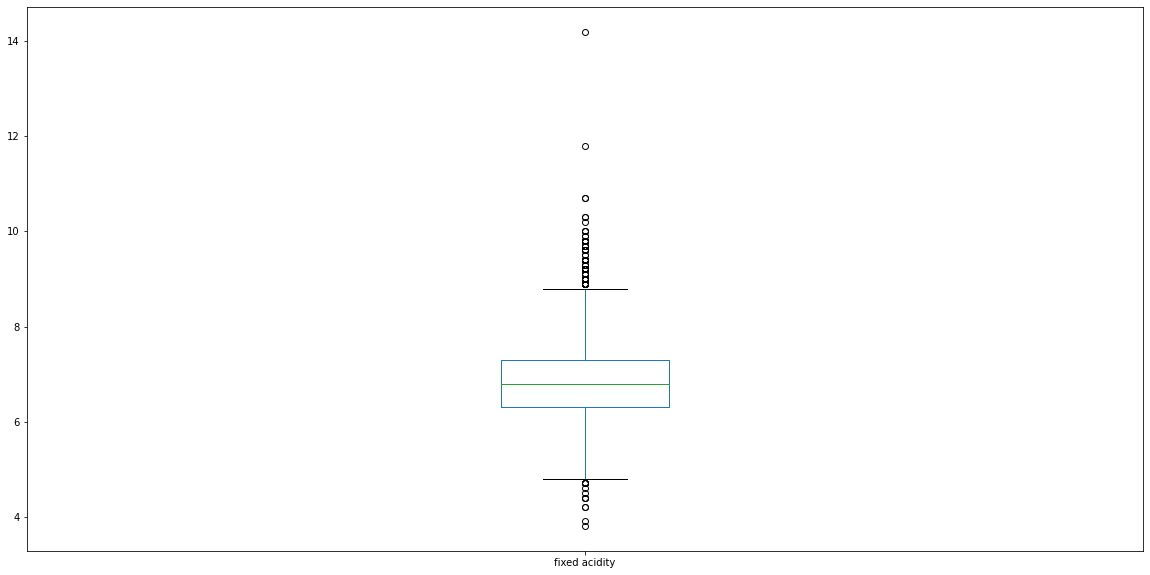

In [9]:
fig = plt.figure(figsize = (20,10))
df.boxplot(column=['fixed acidity'], grid=False)

#### Detect features and target

In [10]:
bins = (1, 4.5, 7.5, 10)
group_names = ['bad', 'good', 'high']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

In [11]:
df['quality'].value_counts()

good    4535
bad      183
high     181
Name: quality, dtype: int64

In [12]:
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

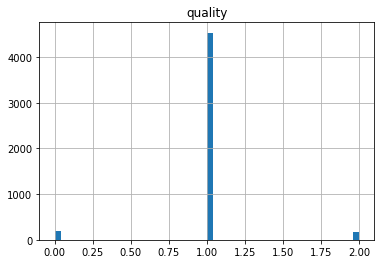

In [13]:
df.hist(column='quality', bins=50)

In [14]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(X.shape)
print(y.shape)

(4899, 11)
(4899,)


#### Preprocessing

In [15]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

(12391, 11)
(12391,)


<AxesSubplot:>

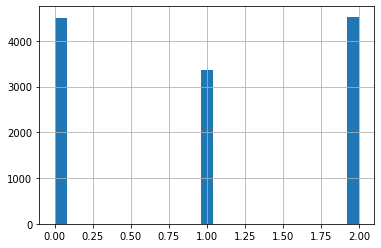

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Balance dataset
over = SMOTEENN()

X, y = over.fit_resample(X, y)
print(X.shape)
print(y.shape)
y.hist(bins=25)

In [16]:
balanced_scaled_df = pd.DataFrame(X, columns = [name for name in list(df.iloc[:, :-1])])

In [17]:
count = 0
for name in list(df.iloc[:, :-1]):
    print(name)
    outliers = iqr_outliers(balanced_scaled_df[name])
    count += len(outliers)
print('Total: ', count)

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
Total:  1081


### Feature selection 

#### By correlation 

<AxesSubplot:>

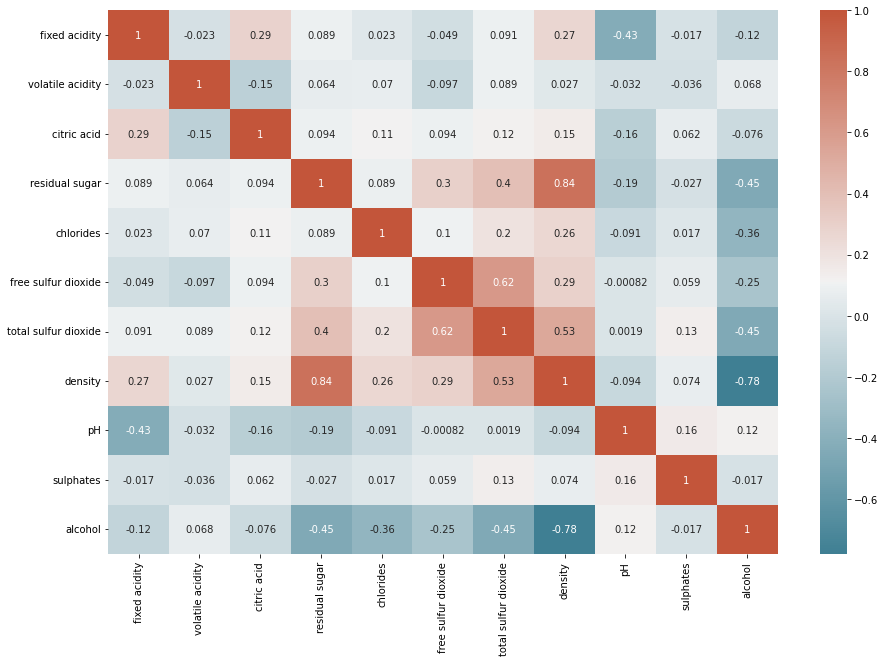

In [18]:
corr = balanced_scaled_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [19]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if abs(corr.iloc[i, j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = balanced_scaled_df.columns[columns]
print(selected_columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH',
       'sulphates', 'alcohol'],
      dtype='object')


In [20]:
reduced_df = balanced_scaled_df[selected_columns]

In [21]:
reduced_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol
0,0.2,0.090909,0.333333,1.890244,0.142857,0.478261,0.610169,-0.947368,-0.142857,-0.842105
1,-0.5,0.363636,0.166667,-0.439024,0.428571,-0.869565,-0.033898,0.631579,0.142857,-0.473684
2,1.3,0.181818,0.666667,0.207317,0.500000,-0.173913,-0.627119,0.421053,-0.214286,-0.157895
3,0.4,-0.272727,0.000000,0.402439,1.071429,0.565217,0.881356,0.052632,-0.500000,-0.263158
4,0.4,-0.272727,0.000000,0.402439,1.071429,0.565217,0.881356,0.052632,-0.500000,-0.263158


In [22]:
X = reduced_df.iloc[:, :].values
print(X.shape)

(4899, 10)


#### Split data in train and test 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [24]:
X_test[:5]

array([[ 0.5       ,  0.27272727,  0.41666667,  0.37804878,  0.07142857,
         0.47826087,  1.57627119, -0.31578947,  0.        , -0.73684211],
       [-0.4       ,  0.18181818, -1.08333333,  0.02439024, -0.07142857,
         1.43478261,  0.79661017,  0.68421053, -0.85714286, -0.10526316],
       [ 0.5       ,  0.        , -0.66666667, -0.42682927,  0.5       ,
        -1.04347826, -0.37288136, -0.36842105, -0.28571429, -0.26315789],
       [ 0.1       ,  0.54545455, -1.41666667,  0.35365854,  0.21428571,
         0.73913043,  0.77966102, -0.26315789, -0.14285714, -0.78947368],
       [-1.7       ,  0.63636364, -0.83333333, -0.43902439, -1.14285714,
        -0.69565217, -0.76271186,  1.73684211, -0.64285714,  1.10526316]])

In [25]:
y_test[:5]

2058    1
1760    1
2971    1
2027    1
374     1
Name: quality, dtype: int64

In [26]:
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (3919, 10) (3919,)
Test set: (980, 10) (980,)


#### Util functions 

In [27]:
def print_cros_val_score(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
    scores = cross_val_score(model, X, y, cv=5, n_jobs = -1)
    print(scores.mean())

In [28]:
all_metrics = {}
def print_metrics(y_pred, model_name=''):

    confusion_mat = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion matrix is : ", confusion_mat)
    
    acc =  metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    print("Recall_score is :", recall)
    
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    print("Precision Score is : ", precision)
    
    f1 = 2 * (recall * precision) / (recall + precision)
    print("F1 score is: ", f1)
    
    jacc = metrics.jaccard_score(y_test, y_pred, average='weighted')
    print("Jaccard: ", jacc)
    
    all_metrics[model_name] = {}
    all_metrics[model_name]['Accuracy'] = acc
    all_metrics[model_name]['Recall_score'] = recall
    all_metrics[model_name]['Precision'] = precision
    all_metrics[model_name]['F1'] = f1
    all_metrics[model_name]['Jaccard'] = jacc
    
    

In [29]:
test_cases = X_test[:3]
expected = [0, 1, 0]

def test_prediction(model):
    y_prediction_test = model.predict(test_cases)
    print("Predicted: ", y_prediction_test)
    print("Expected: ", expected)

In [30]:
def get_best_params(model, param):
    grid_svc = GridSearchCV(model, param_grid=param, scoring='accuracy', cv=10)
    grid_svc.fit(X_train, y_train)
    best = grid_svc.best_params_
    return best

# K nearest neighbor (KNN)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
param = {
    'n_neighbors': [1, 2, 5, 8, 12, 20, 50],
}
get_best_params(KNeighborsClassifier(), param)

{'n_neighbors': 1}

In [31]:
from sklearn.neighbors import KNeighborsClassifier
k = 1
neigh = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
neigh.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

In [36]:
print_cros_val_score(neigh)

0.9698173942798279


In [32]:
y_pred = neigh.predict(X_test)

In [33]:
print_metrics(y_pred, 'KNN')

Confusion matrix is :  [[ 12  26   0]
 [ 22 864  16]
 [  1  27  12]]
Accuracy: 0.9061224489795918
Recall_score is : 0.9061224489795918
Precision Score is :  0.8979983531035097
F1 score is:  0.9020421093246859
Jaccard:  0.8490786736608151


In [86]:
test_prediction(neigh)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


# SVM

In [40]:
from sklearn.svm import SVC

param = {
    'C': [1, 1.2],
    'gamma' :[0.9, 1.2]
}
get_best_params(SVC(), param)

{'C': 1.2, 'gamma': 1.2}

In [34]:
from sklearn.svm import SVC

svc = SVC(C=1.2, gamma=1.2, kernel='rbf')
svc.fit(X_train, y_train)

SVC(C=1.2, gamma=1.2)

In [42]:
print_cros_val_score(svc)

0.9924951188042511


In [35]:
y_pred = svc.predict(X_test)

In [36]:
print_metrics(y_pred, 'SVC')

Confusion matrix is :  [[  2  36   0]
 [  0 900   2]
 [  0  32   8]]
Accuracy: 0.9285714285714286
Recall_score is : 0.9285714285714286
Precision Score is :  0.9271799628942486
F1 score is:  0.9278751740636269
Jaccard:  0.863802310320299


In [46]:
test_prediction(svc)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


In [47]:
from sklearn.svm import NuSVC

param = {
    'nu': [0.2, 0.5, 0.8],
    'gamma' :[0.1, 1, 1.5]
}
get_best_params(NuSVC(), param)

{'gamma': 1.5, 'nu': 0.2}

In [41]:
from sklearn.svm import NuSVC

nuSvc = NuSVC(gamma=1.5, nu=0.0001)
nuSvc.fit(X_train, y_train)

NuSVC(gamma=1.5, nu=0.0001)

In [49]:
print_cros_val_score(nuSvc)

0.9919300168225036


In [42]:
y_pred = nuSvc.predict(X_test)

In [43]:
print_metrics(y_pred, 'NuSVC')

Confusion matrix is :  [[  8  30   0]
 [ 13 882   7]
 [  0  29  11]]
Accuracy: 0.9193877551020408
Recall_score is : 0.9193877551020408
Precision Score is :  0.9024141897030054
F1 score is:  0.9108219018089339
Jaccard:  0.8603802474783612


In [52]:
test_prediction(nuSvc)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


# Bagging

## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

param = {
    'n_estimators': [50, 100, 200],
    'max_features' :['sqrt', 'log2', None]
}
get_best_params(RandomForestClassifier(), param)

{'max_features': 'sqrt', 'n_estimators': 200}

In [44]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = 200
max_features = 'sqrt'
rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [55]:
print_cros_val_score(rf)

0.9659430418094723


In [45]:
y_pred = rf.predict(X_test)

In [46]:
print_metrics(y_pred, 'RandomForestClassifier')

Confusion matrix is :  [[ 10  28   0]
 [  2 898   2]
 [  0  32   8]]
Accuracy: 0.9346938775510204
Recall_score is : 0.9346938775510204
Precision Score is :  0.9277285444449178
F1 score is:  0.9311981860620829
Jaccard:  0.87664360368442


In [58]:
test_prediction(rf)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


## Extra Trees 

In [59]:
from sklearn.ensemble import ExtraTreesClassifier

param = {
    'n_estimators': [50, 100, 200],
    'max_features' :['sqrt', 'log2', None]
}
get_best_params(ExtraTreesClassifier(), param)

{'max_features': 'log2', 'n_estimators': 200}

In [47]:
from sklearn.ensemble import ExtraTreesClassifier


n_estimators = 200
max_features = 'log2'
et = ExtraTreesClassifier(n_estimators=n_estimators, max_features=max_features, random_state=seed)
et.fit(X_train, y_train)

ExtraTreesClassifier(max_features='log2', n_estimators=200, random_state=33)

In [61]:
print_cros_val_score(et)

0.9763538175883231


In [48]:
y_pred = et.predict(X_test)

In [49]:
print_metrics(y_pred, 'ExtraTreesClassifier')

Confusion matrix is :  [[  9  29   0]
 [  4 896   2]
 [  0  31   9]]
Accuracy: 0.9326530612244898
Recall_score is : 0.9326530612244898
Precision Score is :  0.9228817207896706
F1 score is:  0.9277416628194928
Jaccard:  0.8743170508476631


In [64]:
test_prediction(et)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


# Boosting

## AdaBoost 

In [67]:
from sklearn.ensemble import AdaBoostClassifier


param = {
    'n_estimators': [50, 100, 200, 500],
}
get_best_params(AdaBoostClassifier(), param)

{'n_estimators': 200}

In [50]:
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 500
ab = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
ab.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=7)

In [71]:
print_cros_val_score(ab)

0.7810511932191668


In [98]:
y_pred = ab.predict(X_test)

In [51]:
print_metrics(y_pred, 'AdaBoostClassifier')

Confusion matrix is :  [[  9  29   0]
 [  4 896   2]
 [  0  31   9]]
Accuracy: 0.9326530612244898
Recall_score is : 0.9326530612244898
Precision Score is :  0.9228817207896706
F1 score is:  0.9277416628194928
Jaccard:  0.8743170508476631


In [74]:
test_prediction(ab)

Predicted:  [2 0 2]
Expected:  [0, 1, 0]


# Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingClassifier


param = {
    'n_estimators': [100, 500],
    'learning_rate': [0.1, 0.4, 0.7],
    'max_features' :['sqrt', 'log2', None],
}
get_best_params(GradientBoostingClassifier(), param)

{'learning_rate': 0.7, 'max_features': 'log2', 'n_estimators': 500}

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators=500
learning_rate=0.7
max_features='log2'
gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_features=max_features, random_state=seed)
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.7, max_features='log2',
                           n_estimators=500, random_state=33)

In [78]:
print_cros_val_score(gb)

0.9708670833386239


In [53]:
y_pred = gb.predict(X_test)

In [54]:
print_metrics(y_pred, 'GradientBoostingClassifier')

Confusion matrix is :  [[  7  19  12]
 [125 391 386]
 [  2   7  31]]
Accuracy: 0.4377551020408163
Recall_score is : 0.4377551020408163
Precision Score is :  0.8679956217998279
F1 score is:  0.5819939519150327
Jaccard:  0.39233513271542997


In [55]:
test_prediction(gb)

Predicted:  [1 1 0]
Expected:  [0, 1, 0]


In [56]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df['Best'] = metrics_df.idxmax(axis=1)
metrics_df

,KNN,SVC,NuSVC,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,Best
Accuracy,0.906122,0.928571,0.919388,0.934694,0.932653,0.932653,0.437755,RandomForestClassifier
Recall_score,0.906122,0.928571,0.919388,0.934694,0.932653,0.932653,0.437755,RandomForestClassifier
Precision,0.897998,0.927180,0.902414,0.927729,0.922882,0.922882,0.867996,RandomForestClassifier
F1,0.902042,0.927875,0.910822,0.931198,0.927742,0.927742,0.581994,RandomForestClassifier
Jaccard,0.849079,0.863802,0.860380,0.876644,0.874317,0.874317,0.392335,RandomForestClassifier
